<a href="https://colab.research.google.com/github/wallacelw/Price-Forecasting-With-LSTM/blob/main/Prices_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets available @

BTC, AAPL, MSFT, TSLA, ^IXIC(NASDAQ), ^BVSP(IBOVESPA):
https://finance.yahoo.com/

S&P 500:
https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?select=sp500_index.csv

## Load Dataset and Preprocess It:

In [28]:
import pandas as pd
import datetime

def str_to_datetime(s):
    """ Converts a string object to the respective datetime objects"""

    year, month, day = [int(i) for i in s.split('-')]
    return datetime.datetime(year=year, month=month, day=day)


price_dict = {
    "Adj Close" : "Price",
    "S&P500" : "Price"
}

def load_df(filename):
    """
    Create dataframe, filter only Price column,
    convert date to datetime and make it the index
    """

    df = pd.read_csv(filename)
    df.rename(columns = price_dict, inplace = True)

    # Univariate analysis
    df = df[["Date", "Price"]]

    # Convert date type objects to datetime object
    df["Date"] = df["Date"].apply(str_to_datetime)

    # Turn "Date" Column into dataframe index
    df.index = df.pop("Date")

    return df


df = load_df("sp500_index.csv")

df

,Price
Date,
2013-11-04,1767.93
2013-11-05,1762.97
2013-11-06,1770.49
2013-11-07,1747.15
2013-11-08,1770.61
...,...
2023-10-30,4166.82
2023-10-31,4193.80
2023-11-01,4237.86


Text(0.5, 1.0, 'Full Dataset')

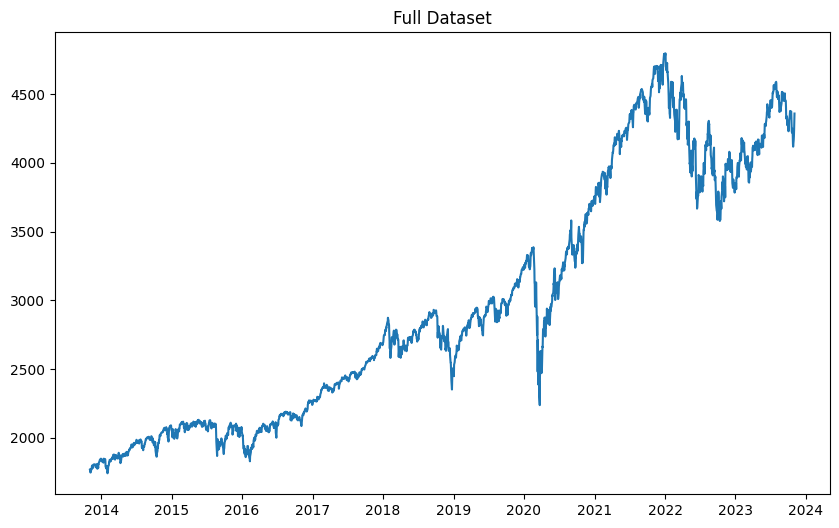

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Price"])
plt.title("Full Dataset")

In [30]:
# Choose the amount of days to consider from the dataset
days = 1800 # 0 for everything

# numbers of days to consider in the input of the model
lookback = 7


def df_to_windowed(df, n=lookback, daysSelected=days):
    """
    Create a windowed Dataframe (converting into a supervised problem).
    Therefore, the last {lookback} days prices will be the (input)
    and will generate the next day price (output)
    """

    tmp_df = pd.DataFrame()
    for i in range(n, 0, -1):
        tmp_df[f"Last-{i} Price"] = df["Price"].shift(periods=i)
    tmp_df["Price"] = df["Price"]

    return tmp_df.dropna()[-daysSelected:]

windowed_df = df_to_windowed(df)

windowed_df

,Last-7 Price,Last-6 Price,Last-5 Price,Last-4 Price,Last-3 Price,Last-2 Price,Last-1 Price,Price
Date,,,,,,,,
2016-09-12,2170.95,2170.86,2179.98,2186.48,2186.16,2181.30,2127.81,2159.04
2016-09-13,2170.86,2179.98,2186.48,2186.16,2181.30,2127.81,2159.04,2127.02
2016-09-14,2179.98,2186.48,2186.16,2181.30,2127.81,2159.04,2127.02,2125.77
2016-09-15,2186.48,2186.16,2181.30,2127.81,2159.04,2127.02,2125.77,2147.26
2016-09-16,2186.16,2181.30,2127.81,2159.04,2127.02,2125.77,2147.26,2139.16
...,...,...,...,...,...,...,...,...
2023-10-30,4278.00,4224.16,4217.04,4247.68,4186.77,4137.23,4117.37,4166.82
2023-10-31,4224.16,4217.04,4247.68,4186.77,4137.23,4117.37,4166.82,4193.80
2023-11-01,4217.04,4247.68,4186.77,4137.23,4117.37,4166.82,4193.80,4237.86


## Models

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

models = [
    Sequential([
        layers.Input((lookback, 1)),
        layers.Conv1D(128, kernel_size=5),
        layers.Conv1D(128, kernel_size=3),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(128, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.01), # avoid overfitting
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ]),

    Sequential([
        layers.Input((lookback, 1)),
        layers.Conv1D(128, kernel_size=5, activation='relu'),
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(128, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.01), # avoid overfitting
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ]),

    Sequential([
        layers.Input((lookback, 1)),
        layers.Conv1D(64, kernel_size=3),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.02), # avoid overfitting
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
]

## Model Training

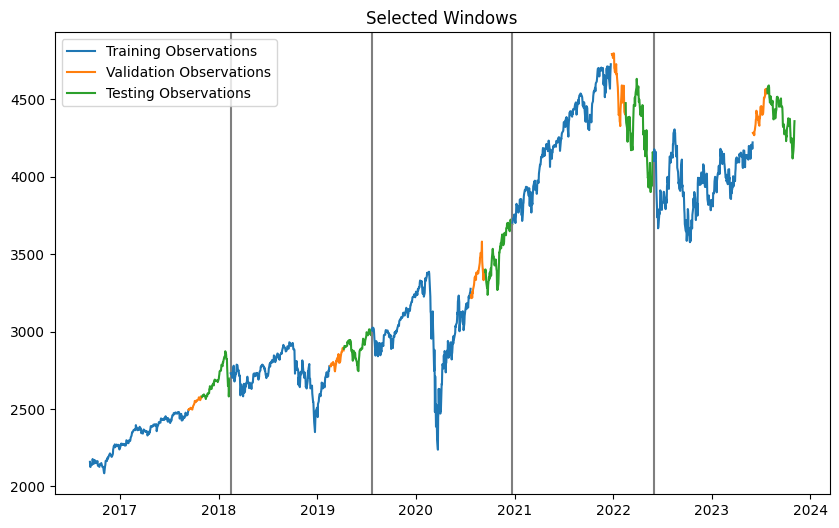

In [32]:
# For each year, 70% train, 10% validation, 20% test
def sliding_window_generator(windowed, trainSize=252, valiSize=36, testSize=72, step=360):
    """
    Sliding Window Generator
    """

    for i in range(0, len(windowed) - trainSize - testSize - valiSize + 1, step):
        train_slice = windowed[i : i+trainSize]
        vali_slice = windowed[i+trainSize : i+trainSize+valiSize]
        test_slice = windowed[i+trainSize+valiSize : i+trainSize+valiSize+testSize]
        yield (train_slice, vali_slice, test_slice)

plot_generator = sliding_window_generator(windowed_df)
plt.figure(figsize=(10,6))
plt.title("Selected Windows")
skip = True
for train, vali, test in plot_generator:
    if (skip):
        skip = False
    else:
        plt.axvline(train.index[0], color="tab:gray")
    plt.plot(train.index, train["Price"], color="tab:blue")
    plt.plot(vali.index, vali["Price"], color="tab:orange")
    plt.plot(test.index, test["Price"], color="tab:green")

plt.legend([
    "Training Observations",
    "Validation Observations",
    "Testing Observations",
])
plt.show()

In [33]:
def split_xy(windowedNP):
    """
    Split np.array into X and y
    """

    X = windowedNP[:, :-1]
    y = windowedNP[:, -1]
    return (X, y)

3/3 [==============================] - 1s 6ms/step


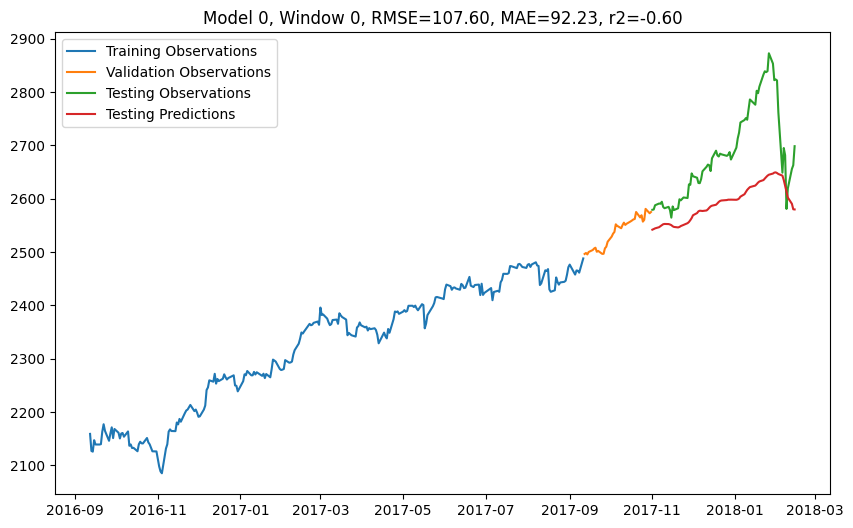

3/3 [==============================] - 0s 6ms/step


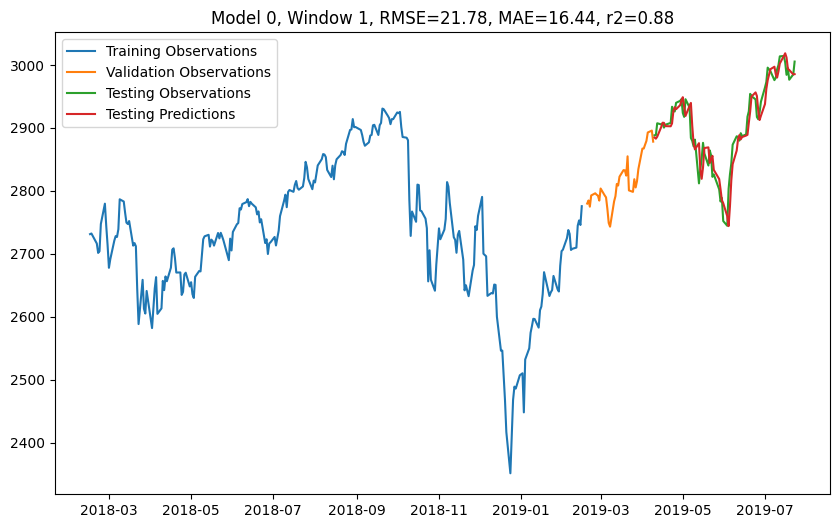

3/3 [==============================] - 0s 7ms/step


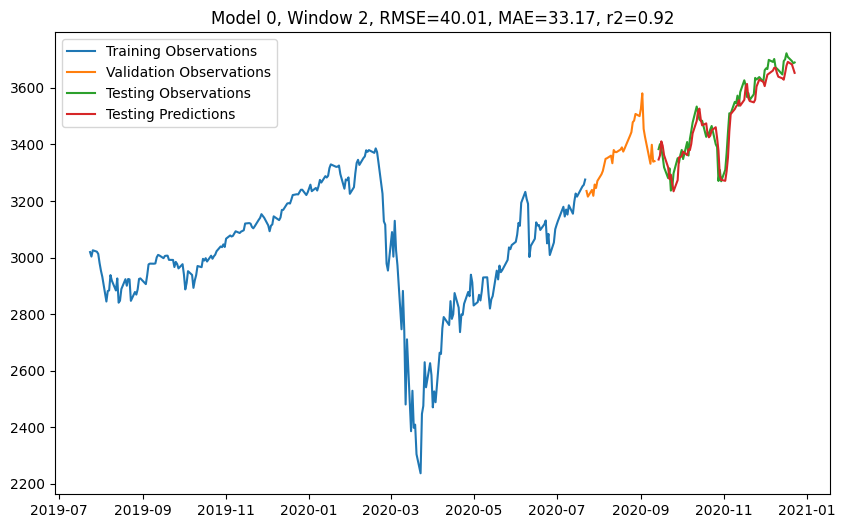

3/3 [==============================] - 0s 7ms/step


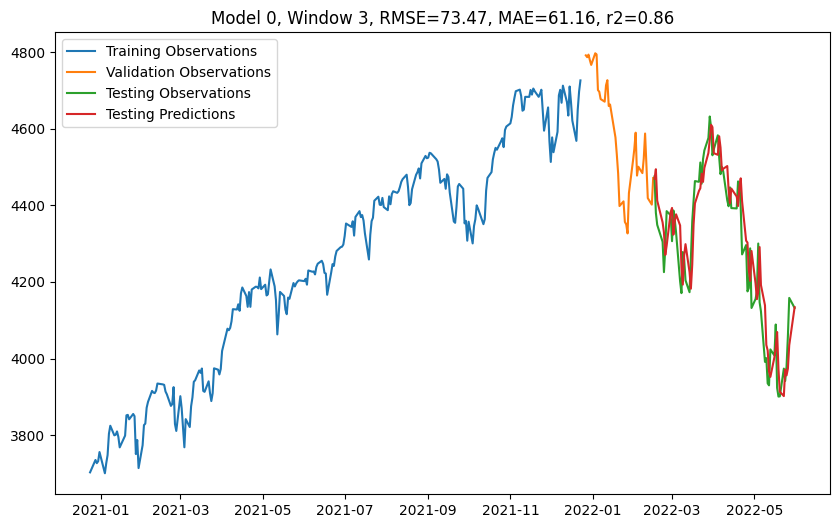

3/3 [==============================] - 0s 7ms/step


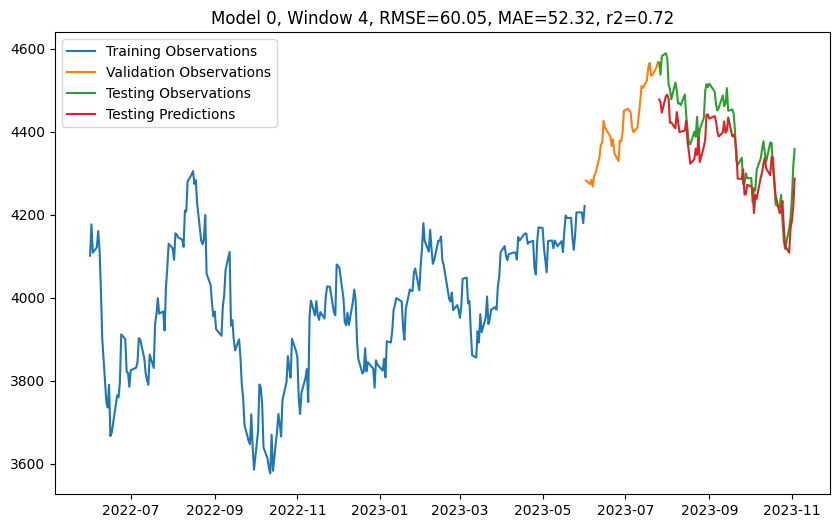

3/3 [==============================] - 1s 6ms/step


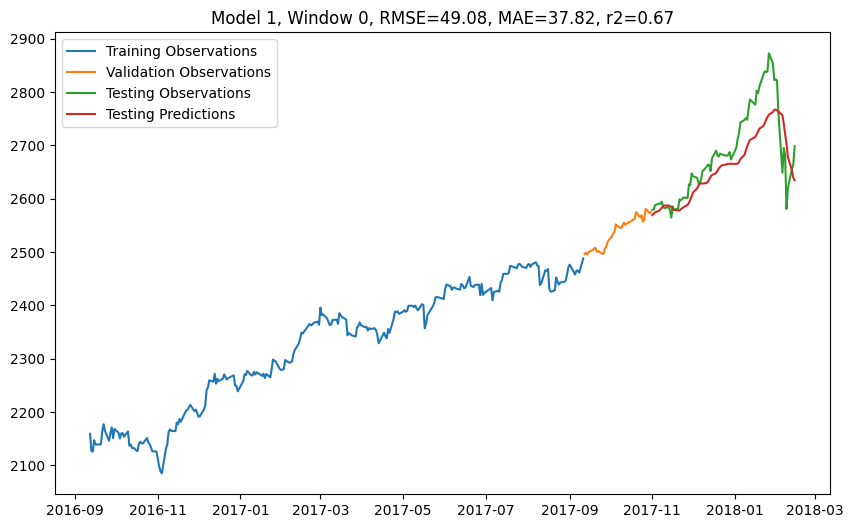

3/3 [==============================] - 0s 8ms/step


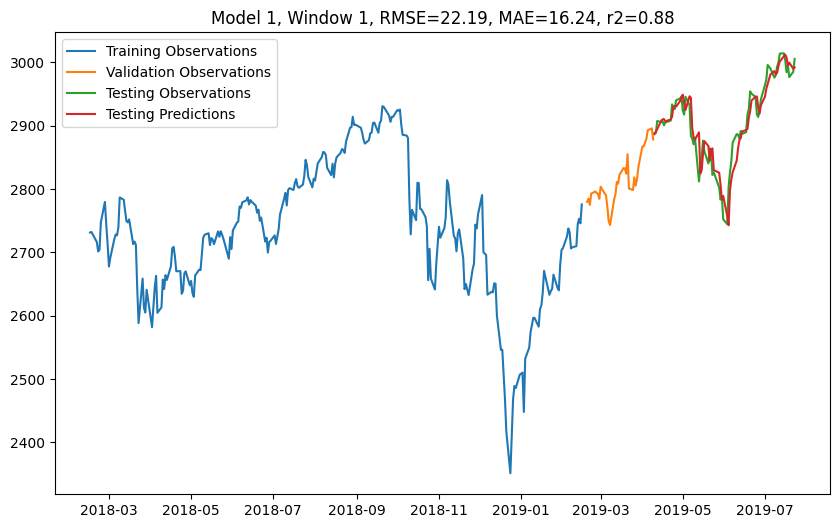

3/3 [==============================] - 0s 11ms/step


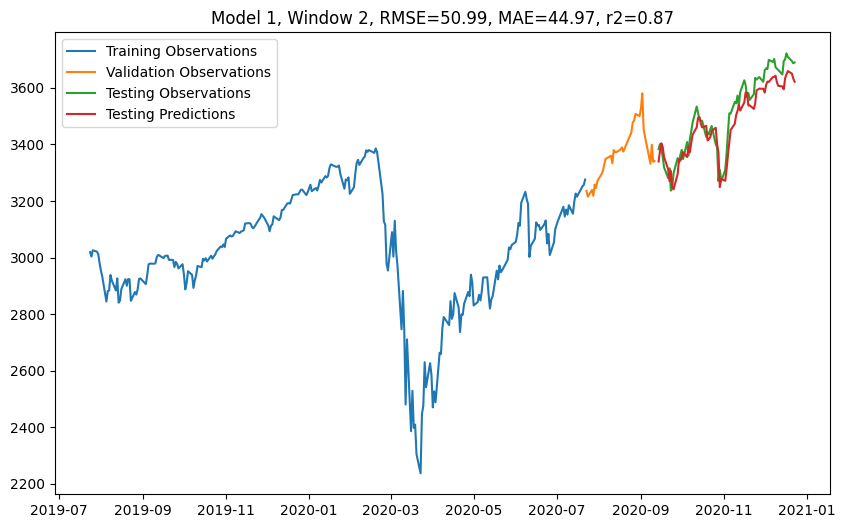

3/3 [==============================] - 0s 7ms/step


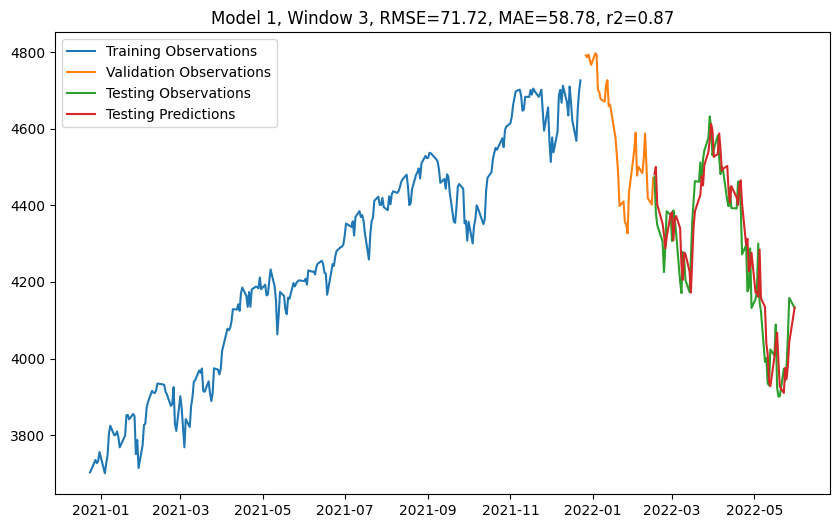

3/3 [==============================] - 0s 9ms/step


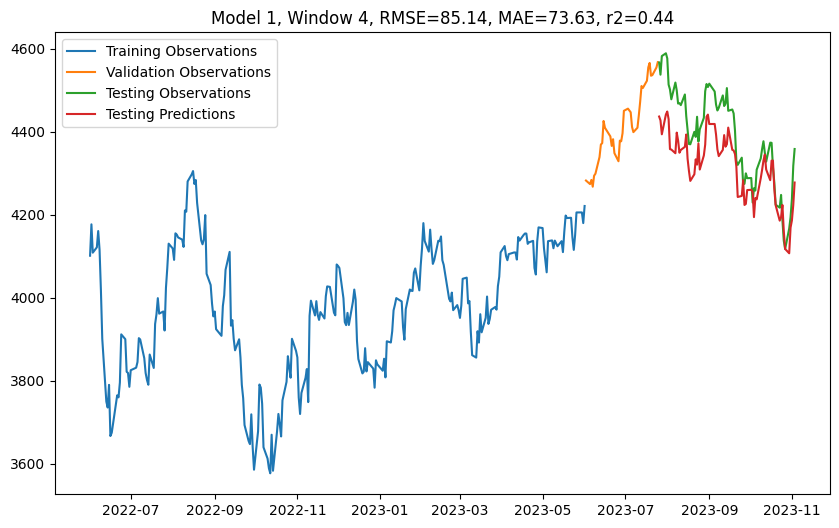

3/3 [==============================] - 0s 8ms/step


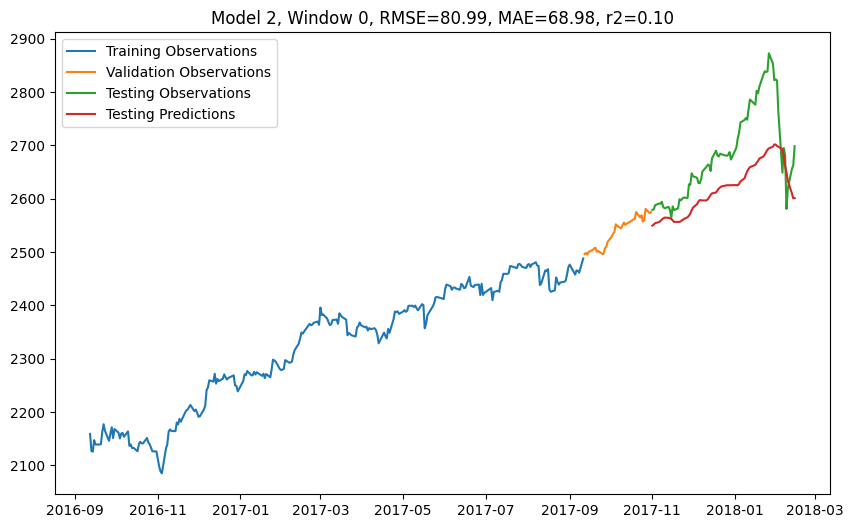

3/3 [==============================] - 0s 7ms/step


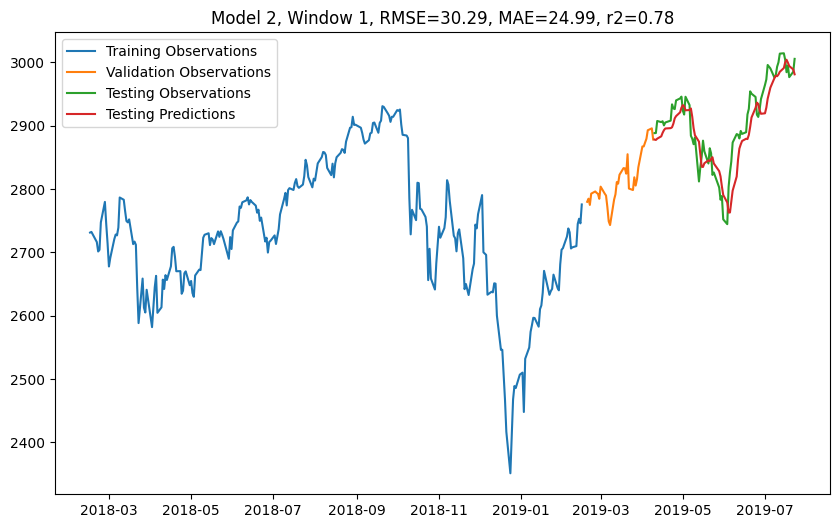

3/3 [==============================] - 0s 5ms/step


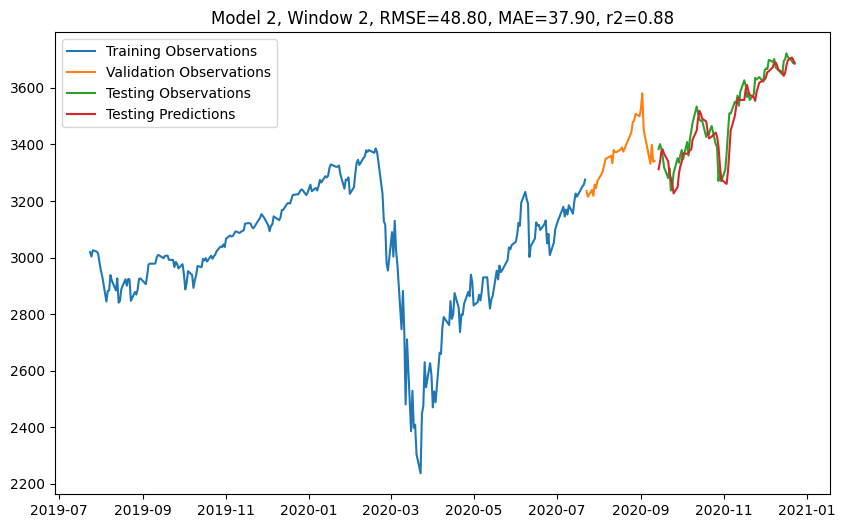

3/3 [==============================] - 0s 6ms/step


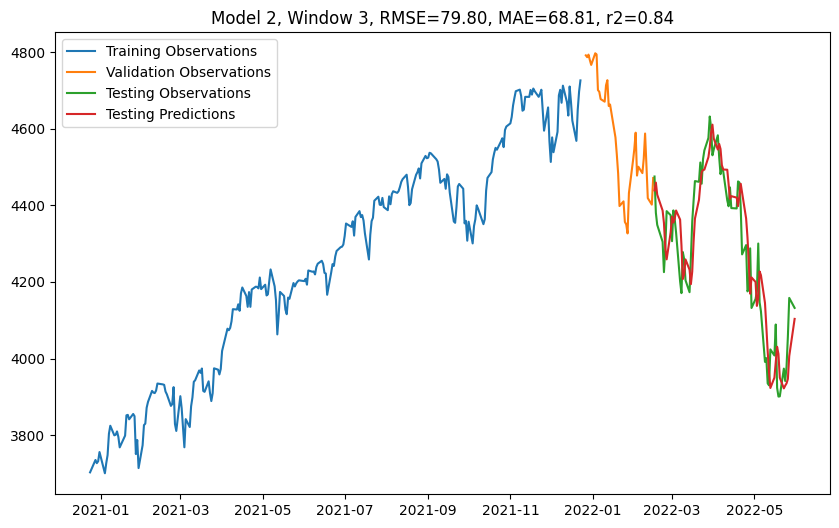

3/3 [==============================] - 0s 7ms/step


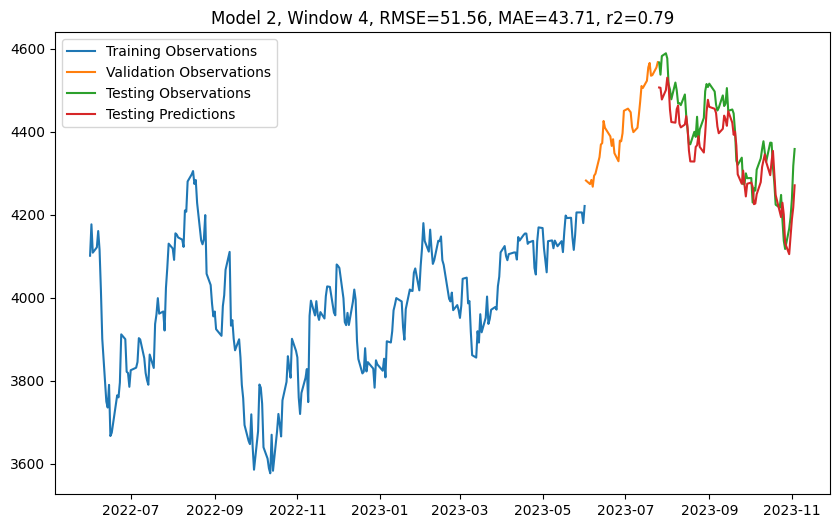

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def cross_validation_score(model, generator, model_idx):
    """
    Calculates the cross validation score ("RMSE", "MAE", "R2")
    """

    cv_score = pd.DataFrame(columns=["RMSE", "MAE", "R2"])

    for i, (train, vali, test) in enumerate(generator):

        # Get Dates
        dates_train = train.index
        dates_vali = vali.index
        dates_test = test.index

        # Get Scaled Data
        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_train_sc, y_train_sc = split_xy(scaler.fit_transform(train))
        X_vali_sc, y_vali_sc = split_xy(scaler.transform(vali))
        X_test_sc, y_test_sc = split_xy(scaler.transform(test))

        # Fit and Predict
        model.fit(
            X_train_sc, y_train_sc,
            validation_data=(X_vali_sc, y_vali_sc),
            epochs=100,
            batch_size=64,
            verbose=False
        )
        preds_sc = model.predict(X_test_sc)

        # Get Non-Scaled Data
        result = scaler.inverse_transform(np.hstack((X_test_sc, preds_sc)))
        X_train, y_train = split_xy(train.to_numpy())
        X_vali, y_vali = split_xy(vali.to_numpy())
        X_test, y_test = split_xy(test.to_numpy())
        X_result, y_result = split_xy(result)

        # Compute Metrics
        rmse = mean_squared_error(y_true=y_test, y_pred=y_result, squared=False)
        mae = mean_absolute_error(y_true=y_test, y_pred=y_result)
        r2 = r2_score(y_true=y_test, y_pred=y_result)

        # Plot Curves and Metrics
        plt.figure(figsize=(10,6))
        plt.plot(dates_train, y_train)
        plt.plot(dates_vali, y_vali)
        plt.plot(dates_test, y_test)
        plt.plot(dates_test, y_result)
        plt.legend([
            "Training Observations",
            "Validation Observations",
            "Testing Observations",
            "Testing Predictions"
        ])
        plt.title(f"Model {model_idx}, Window {i}, RMSE={rmse:.2f}, MAE={mae:.2f}, r2={r2:.2f}")
        plt.show()

        # Append Result
        cv_score.loc[len(cv_score)] = [rmse, mae, r2]


    return cv_score

# For each model, perform a cross validation training,
# plot graphs and compute metrics
cv_scores = []
for i, model in enumerate(models):
    model.compile(
        loss="mean_squared_error",
        optimizer=Adam(learning_rate=0.0001)
    )
    generator = sliding_window_generator(windowed_df)
    cv_score = cross_validation_score(model, generator, i)
    cv_scores.append(cv_score)

## Results

In [41]:
for i, cv_score in enumerate(cv_scores):
    print(f"Model {i}")
    print(cv_score)
    print(cv_score.describe(), "\n\n")

Model 0
         RMSE        MAE        R2
0  107.599495  92.231894 -0.596381
1   21.783874  16.436170  0.883746
2   40.005664  33.172653  0.920505
3   73.473003  61.155632  0.862092
4   60.048828  52.317913  0.719571
             RMSE        MAE        R2
count    5.000000   5.000000  5.000000
mean    60.582173  51.062853  0.557907
std     32.809249  28.798419  0.649748
min     21.783874  16.436170 -0.596381
25%     40.005664  33.172653  0.719571
50%     60.048828  52.317913  0.862092
75%     73.473003  61.155632  0.883746
max    107.599495  92.231894  0.920505 


Model 1
        RMSE        MAE        R2
0  49.084306  37.818942  0.667799
1  22.188235  16.241430  0.879390
2  50.994957  44.970558  0.870834
3  71.716933  58.778410  0.868606
4  85.144923  73.629627  0.436191
            RMSE        MAE        R2
count   5.000000   5.000000  5.000000
mean   55.825871  46.287793  0.744564
std    24.043760  21.678514  0.193969
min    22.188235  16.241430  0.436191
25%    49.084306  37.81894